# Train a deep CNN on XPS data on Google Colab

In this notebook, we will train a deep convolutional network on iron XPS spectra made up of linear combinations of single iron reference spectra.

## Setup

### Mount google drive, change working directory

In [1]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')

# Change working path
os.chdir('/content/drive/My Drive/deepxps')

Mounted at /content/drive


### Install packages and import modules

In [2]:
%%capture
# Install packages
!pip install python-docx

# Import standard modules and magic commands
import datetime
import numpy as np
import pytz
import importlib

# Set random seed for reproducible loading
np.random.seed(502)

# Magic commands
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Disable tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf

### Check TensorFlow version

In [3]:
tf.__version__

'2.4.1'

### Check TPU connection

In [ ]:
from tensorflow.python.profiler import profiler_client

tpu_profile_service_address = os.environ['COLAB_TPU_ADDR'].replace('8470', '8466')
print(profiler_client.monitor(tpu_profile_service_address, 100, 2))

## Initial training

### Load custom modules

In [4]:
try:
    importlib.reload(classifier)
    importlib.reload(clfutils)
    print('Modules were reloaded.')
except:
    import xpsdeeplearning.network.classifier as classifier
    import xpsdeeplearning.network.utils as clfutils
    print('Modules were loaded.')

Modules were loaded.


### Set up the parameters & folder structure



In [5]:
time = datetime.datetime.now().astimezone(pytz.timezone('Europe/Berlin')).strftime("%Y%m%d_%Hh%Mm")
exp_name = 'Ti_4_classes_linear_comb_small_gas_phase_resnet'

clf = classifier.Classifier(time = time,
                            exp_name = exp_name,
                            task = 'regression',
                            intensity_only = True)

### If labels not saved with data ###
# =============================================================================
# labels = ['Fe metal', 'FeO', 'Fe3O4', 'Fe2O3']
# clf = classifier.Classifier(time = time,
#                            exp_name = exp_name,
#                            task = 'regression',
#                            intensity_only = True,
#                            labels = labels)
# =============================================================================

Model folder created at /saved_models/20210329_12h51m_Ti_4_classes_linear_comb_small_gas_phase_resnet
Logs folder created at /logs/20210329_12h51m_Ti_4_classes_linear_comb_small_gas_phase_resnet
Figures folder created at /figures/20210329_12h51m_Ti_4_classes_linear_comb_small_gas_phase_resnet


### Load and inspect the data

Data was loaded!
Total no. of samples: 200000
No. of training samples: 128000
No. of validation samples: 32000
No. of test samples: 40000
Shape of each sample : 1057 features (X) + 4 labels (y)


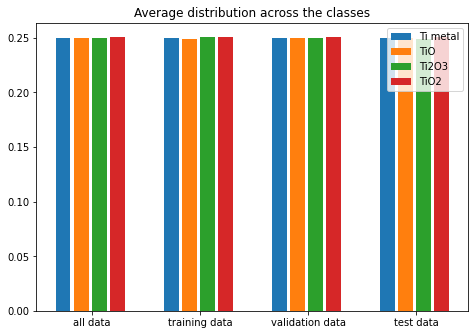

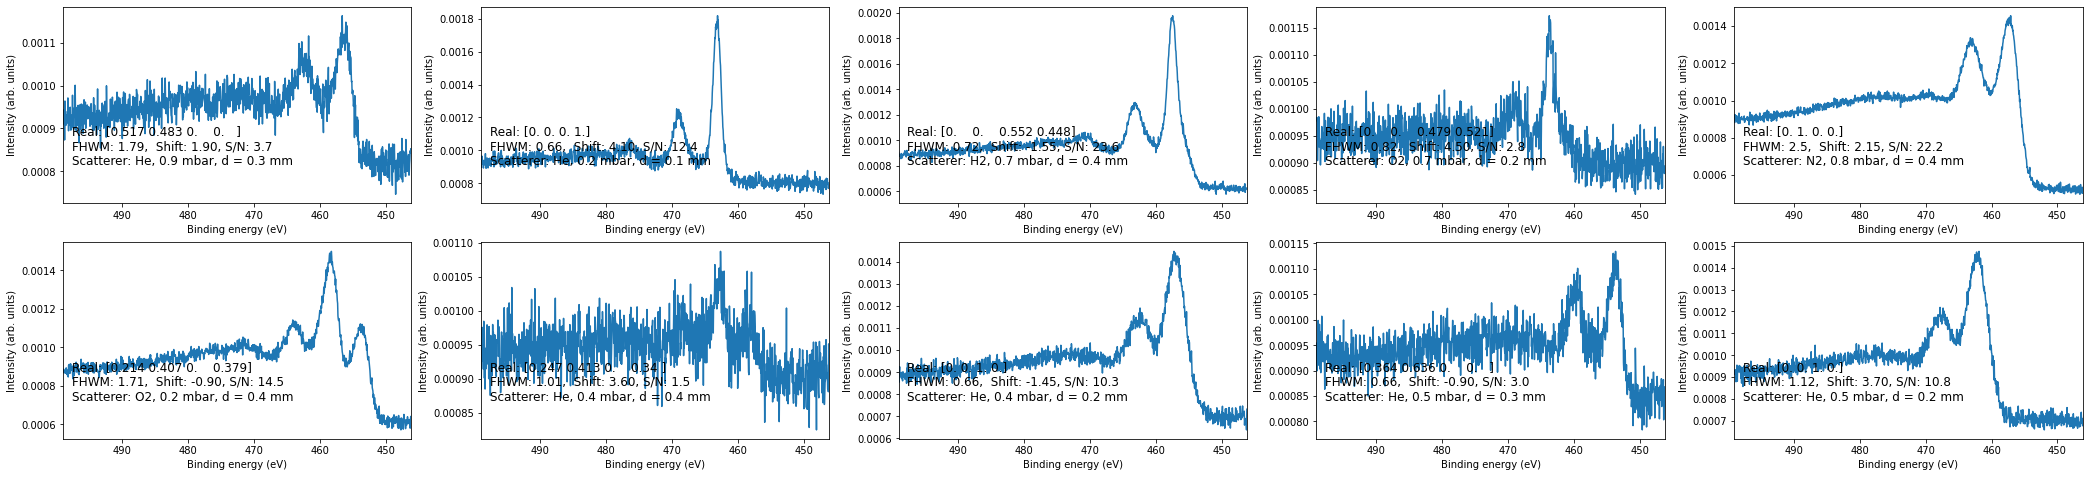

In [6]:
input_filepath = r'/content/drive/My Drive/deepxps/datasets/20210318_Ti_linear_combination_small_gas_phase.h5'

train_test_split = 0.2
train_val_split = 0.2
no_of_examples = 200000

X_train, X_val, X_test, y_train, y_val, y_test,\
    aug_values_train, aug_values_val, aug_values_test =\
        clf.load_data_preprocess(input_filepath = input_filepath,
                                 no_of_examples = no_of_examples,
                                 train_test_split = train_test_split,
                                 train_val_split = train_val_split)
               
# Check how the examples are distributed across the classes.
class_distribution = clf.datahandler.check_class_distribution(clf.task)
clf.plot_class_distribution()
clf.plot_random(no_of_spectra = 10, dataset = 'train')  

### Design the model

In [7]:
try:
    importlib.reload(models)
    print('Models module was reloaded.')
except:
    import xpsdeeplearning.network.models as models
    print('Models module was loaded.')

Models module was loaded.


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.python.keras import backend as K

class RegressionCNN(models.EmptyModel):
    """
    A CNN with three convolutional layers of different kernel size at 
    the beginning. Works well for learning across scales.
    
    This is to be used for regression on all labels. -> sigmoid 
    activation in the last layer.
    """
    def __init__(self, inputshape, num_classes):      
        self.input_1 = layers.Input(shape = inputshape)
                


        self.conv_1_short = layers.Conv1D(filters=12,
                                          kernel_size=5,
                                          strides=1,
                                          padding='same',
                                          activation='relu',
                                          name='conv_1_short')(self.input_1)
        self.conv_1_medium = layers.Conv1D(filters=12,
                                           kernel_size=10,
                                           strides=1,
                                           padding='same',
                                           activation='relu',
                                           name='conv_1_medium')(self.input_1)
        self.conv_1_long = layers.Conv1D(filters=12,
                                         kernel_size=15,
                                         strides=1,
                                         padding='same',
                                         activation='relu',
                                         name='conv_1_long')(self.input_1)
        
        sublayers = [self.conv_1_short, self.conv_1_medium, self.conv_1_long]
        merged_sublayers = layers.concatenate(sublayers)

        self.conv_2 = layers.Conv1D(filters=10,
                                    kernel_size=5,
                                    strides=1,
                                    padding='valid',
                                    activation='relu',
                                    name='conv_2')(merged_sublayers)
        self.conv_3 = layers.Conv1D(filters=10,
                                    kernel_size=5,
                                    strides=1,
                                    padding='valid',
                                    activation='relu',
                                    name="conv_3")(self.conv_2)
        self.average_pool_1 = layers.AveragePooling1D(
            name='average_pool_1')(self.conv_3)
        
        self.flatten_1 = layers.Flatten(name='flatten1')(self.average_pool_1)
        self.drop_1 = layers.Dropout(rate=0.2,
                                     name='drop_1')(self.flatten_1)
        self.dense_1 = layers.Dense(units=4000,
                                    activation='relu',
                                    name='dense_1')(self.drop_1)
        self.dense_2 = layers.Dense(units=num_classes,
                                    activation='sigmoid',
                                    name='dense_2')(self.dense_1)
        
        self.output_norm = layers.Lambda(
            lambda x: x/tf.reshape(K.sum(x, axis=-1),(-1,1)),
            name = 'output_normalization')(self.dense_2)

        no_of_inputs = len(sublayers)

        super(RegressionCNN, self).__init__(inputs=self.input_1,
                                            outputs=self.output_norm,
                                            inputshape=inputshape,
                                            num_classes=num_classes,
                                            no_of_inputs=no_of_inputs,
                                            name='RegressionCNN')

#### Build the model

In [9]:
# =============================================================================
# clf.model = RegressionCNN(clf.datahandler.input_shape,
#                           clf.datahandler.num_classes)
# =============================================================================
# =============================================================================
# clf.model = ResNet1D(clf.datahandler.input_shape,
#                      clf.datahandler.num_classess,
#                      ap=True)
# =============================================================================

# Alternative: Build model from available models in models.py
# =============================================================================
# clf.model = models.RegressionCNN(clf.datahandler.input_shape, 
#                                  clf.datahandler.num_classes)
# =============================================================================
# =============================================================================
# clf.model = models.ResNet1D(clf.datahandler.input_shape,
#                             clf.datahandler.num_classes,
#                             ap=True)
# =============================================================================
clf.model = models.ResNet1D(clf.datahandler.input_shape,
                            clf.datahandler.num_classes,
                            ap=True)

### Compile and summarize the model

Model: "ResNet1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1057, 1)]         0         
_________________________________________________________________
zero_padding1d (ZeroPadding1 (None, 1063, 1)           0         
_________________________________________________________________
stage1_conv (Conv1D)         (None, 1062, 64)          192       
_________________________________________________________________
stage1_bn (BatchNormalizatio (None, 1062, 64)          4248      
_________________________________________________________________
stage1_act (Activation)      (None, 1062, 64)          0         
_________________________________________________________________
stage1_max_pool (MaxPooling1 (None, 1062, 64)          0         
_________________________________________________________________
2a_CONV (ConvBlock)          (None, 531, 128)          395

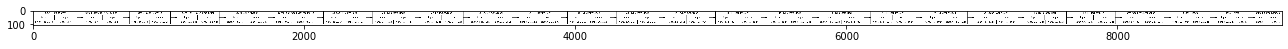

In [10]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.losses import CategoricalCrossentropy

learning_rate = 1e-05
optimizer = Adam(learning_rate = learning_rate) 

if clf.task == 'regression':
    mae = MeanAbsoluteError()
    clf.model.compile(loss = mae, optimizer = optimizer)
    # =============================================================================
    # mse = MeanSquaredError()
    # clf.model.compile(loss = mse, optimizer = optimizer)
    # =============================================================================
    
elif clf.task == 'classification':
    categorical_crossentropy = CategoricalCrossentropy()
    clf.model.compile(loss = categorical_crossentropy,
                      optimizer = optimizer,
                      metrics = ['accuracy'])

# Plot summary and save model plot.
clf.summary()
clf.save_and_print_model_image()

### Show initial predictions

In [11]:
pred_train_initial, pred_test_initial = clf.predict()

print('Train:')
for i in range(5):
    print('real: ' + str(np.round(y_train[i],3)),
          'pred: ' + str(pred_train_initial[i]))
print('Test:')
for i in range(5):
    print('real: ' + str(np.round(y_test[i],3)),
          'pred: ' + str(pred_test_initial[i]))

1250/1250 [==============================] - 59s 47ms/step
Prediction done!
Train:
real: [1. 0. 0. 0.] pred: [0.24999869 0.249982   0.25000793 0.2500114 ]
real: [0.157 0.    0.    0.843] pred: [0.24999726 0.24998164 0.25000682 0.25001428]
real: [0.    0.    0.311 0.689] pred: [0.25000054 0.24998096 0.2500073  0.25001127]
real: [0.    0.    0.431 0.569] pred: [0.25000072 0.2499812  0.25000668 0.25001144]
real: [0.377 0.    0.    0.623] pred: [0.24999946 0.24998152 0.25000754 0.25001138]
Test:
real: [1. 0. 0. 0.] pred: [0.2500011  0.2499795  0.25000829 0.25001115]
real: [0.357 0.145 0.    0.498] pred: [0.24999887 0.24998051 0.25000668 0.25001392]
real: [0.248 0.    0.396 0.355] pred: [0.25000173 0.24997965 0.2500066  0.25001204]
real: [0.    0.202 0.516 0.282] pred: [0.24999937 0.24998209 0.25000694 0.25001162]
real: [0.239 0.271 0.228 0.261] pred: [0.25000143 0.2499783  0.25000858 0.25001168]


### Train

In [12]:
epochs = 1000
batch_size = 32

hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 hyperparam_log = True,
                 epochs = epochs, 
                 batch_size = batch_size,
                 verbose = 1)

sound = False
if sound:
    from google.colab import output
    output.eval_js('new Audio("http://soundbible.com/grab.php?id=1795&type=mp3").play()')

Epoch 1/1000
4000/4000 [==============================] - 841s 207ms/step - loss: 0.1509 - val_loss: 0.0961


NotImplementedError: ignored

### Plot loss

In [ ]:
graph = clfutils.TrainingGraphs(clf.logging.history, clf.logging.fig_dir)
graph.plot_loss(to_file = True)
if clf.task == 'classification':
    graph.plot_accuracy(to_file = False)

### Evaluate on test data

In [ ]:
if clf.task == 'classification':
    score = clf.evaluate()
    test_loss, test_accuracy = score[0], score[1]
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))
    print('Test accuracy: ' + str(np.round(test_accuracy, decimals=3)))
elif clf.task == 'regression':
    test_loss = clf.evaluate()
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))

###  Predict on train and test data

In [ ]:
pred_train, pred_test = clf.predict()
if clf.task == 'classification':
    pred_train_classes, pred_test_classes = clf.predict_classes()

### Show some predictions

#### 10 random training samples

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = 'train', with_prediction = True)  

#### 10 random test samples

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = 'test', with_prediction = True)  

### Show wrong/worst predictions

In [ ]:
if clf.task == 'classification':
    clf.show_wrong_classification()
elif clf.task == 'regression':
    clf.show_worst_predictions(no_of_spectra = 20)  

### Save model and results

In [ ]:
#clf.save_model()
clf.pickle_results()

### Generate report

In [ ]:
dir_name = clf.time + '_' + clf.exp_name
rep = clfutils.Report(dir_name)  
rep.write()

## Continue training

### Load custom modules

In [ ]:
try:
    import importlib
    importlib.reload(classifier)
    importlib.reload(clfutils)
    print('\n Modules were reloaded.')
except:
    import xpsdeeplearning.network.classifier as classifier
    import xpsdeeplearning.network.utils as clfutils
    print('\n Modules were loaded.')

### Reload classifier from logpath

In [ ]:
logpath = r'/content/drive/My Drive/deepxps/logs/20210324_15h22m_Fe_unscattered_4_classes_small_gas_phase_transfer_from_Ti_20210321_22h07m_1000_dense_units'
clf = classifier.restore_clf_from_logs(logpath)

### Load and inspect the data

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test,\
    aug_values_train, aug_values_val, aug_values_test =\
        clf.load_data_preprocess(input_filepath = clf.logging.hyperparams['input_filepath'],
                                 no_of_examples = clf.logging.hyperparams['no_of_examples'],
                                 train_test_split = clf.logging.hyperparams['train_test_split'],
                                 train_val_split = clf.logging.hyperparams['train_val_split'])
                
# Check how the examples are distributed across the classes.
class_distribution = clf.datahandler.check_class_distribution(clf.task)
clf.plot_class_distribution()
clf.plot_random(no_of_spectra = 10, dataset = 'train')  

### Load the model

In [ ]:
clf.load_model(compile_model = True)

### Summarize the model

In [ ]:
# Plot summary and save model plot.
clf.summary()
clf.save_and_print_model_image()

### Show predictions with current model

In [ ]:
pred_train_intermediate, pred_test_intermediate = clf.predict()

print('Train:')
for i in range(5):
    print('real: ' + str(np.round(y_train[i],3)),
          'pred: ' + str(pred_train_intermediate[i]))
print('Test:')
for i in range(5):
    print('real: ' + str(np.round(y_test[i],3)),
          'pred: ' + str(pred_test_intermediate[i]))

### Train

In [ ]:
epochs = 500 #1000

new_learning_rate = 1e-05#5e-06

hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 hyperparam_log = True,
                 epochs = epochs, 
                 batch_size = clf.logging.hyperparams['batch_size'],
                 verbose = 1,)
#                 new_learning_rate = new_learning_rate)

### Show predictions with current model

In [ ]:
pred_train_intermediate, pred_test_intermediate = clf.predict()

print('Train:')
for i in range(5):
    print('real: ' + str(np.round(y_train[i],3)),
          'pred: ' + str(pred_train_intermediate[i]))
print('Test:')
for i in range(5):
    print('real: ' + str(np.round(y_test[i],3)),
          'pred: ' + str(pred_test_intermediate[i]))

### Train

In [ ]:
epochs = 500 #1000

new_learning_rate = 1e-05#5e-06

hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 hyperparam_log = True,
                 epochs = epochs, 
                 batch_size = clf.logging.hyperparams['batch_size'],
                 verbose = 1,)
#                 new_learning_rate = new_learning_rate)

### Plot loss

In [ ]:
graph = clfutils.TrainingGraphs(clf.logging.history, clf.logging.fig_dir)
graph.plot_loss(to_file = True)
if clf.task == 'classification':
    graph.plot_accuracy(to_file = True)

### Evaluate on test data

In [ ]:
if clf.task == 'classification':
    score = clf.evaluate()
    test_loss, test_accuracy = score[0], score[1]
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))
    print('Test accuracy: ' + str(np.round(test_accuracy, decimals=3)))
elif clf.task == 'regression':
    test_loss = clf.evaluate()
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))

###  Predict on train and test data

In [ ]:
pred_train, pred_test = clf.predict()
if clf.task == 'classification':
    pred_train_classes, pred_test_classes = clf.predict_classes()

### Show some predictions

#### 10 random training samples

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = 'train', with_prediction = True)  

#### 10 random test samples

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = 'test', with_prediction = True)  

### Show wrong/worst predictions

In [ ]:
if clf.task == 'classification':
    clf.show_wrong_classification()
elif clf.task == 'regression':
    clf.show_worst_predictions(no_of_spectra = 20)  

### Save model and data

In [ ]:
#clf.save_model()
clf.pickle_results()

### Generate report

In [ ]:
dir_name = clf.time + '_' + clf.exp_name
rep = clfutils.Report(dir_name)  
rep.write()

## Save output of notebook

In [ ]:
from IPython.display import Javascript, display
from nbconvert import HTMLExporter

def save_notebook():
    display(Javascript("IPython.notebook.save_notebook()"),
            include=['application/javascript'])

def output_HTML(read_file, output_file):
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

import time
import os

time.sleep(20)
save_notebook()
print('Notebook saved!')
time.sleep(30)
current_file = '/content/drive/My Drive/deepxps/xpsdeeplearning/train.ipynb'
output_file = os.path.join(clf.logging.log_dir,'train_out.html')
output_HTML(current_file, output_file)
print('HTML file saved!')